# Prototyping Settings for Simplistic DESC SRD Y1 after PGD implementation and average over 100 maps 

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000

We will use a kappa TNG map as a reference point.

In [1]:
%pylab inline 
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle
import flowpm.scipy.interpolate as interpolate
import astropy.units as u
import jax_cosmo as jc
import pickle
from flowpm import tfpm

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
z_source = np.array([1.])

In [3]:
import os
kmap_array=[]
def Load():
    for filename in os.listdir("/global/cscratch1/sd/dlan/plot_paper2/"):
        content =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/plot_paper2/', filename), 'rb'))
        kmap = content['map'].reshape([1, field_npix, field_npix])
        kmap_array.append(kmap)


In [4]:
Load()

In [5]:
ps_array=[]
jac_array=[]
for kmap in (kmap_array):
    l,ps=DHOS.statistics.power_spectrum(kmap[0],field_size,field_npix)
    ps_array.append(ps)


In [6]:
ps_mean=np.mean(ps_array,axis=0)

## Comparison to halofit computed by Jax_cosmo

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [7]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


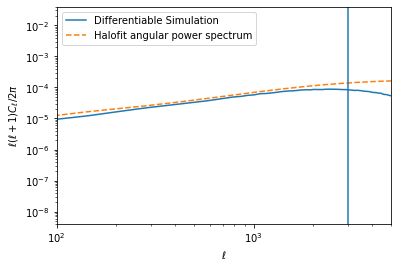

In [8]:
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation')
loglog(l, l*(l+1)*cls[0]/(2*np.pi),'--',label='Halofit angular power spectrum')
xlim(1e2,5e3)
ylim(4e-9,4e-2)
#axvline(300)
axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [9]:
kTNG = np.load('kappa_tng.npy')

In [10]:
l, ps_TNG=DHOS.statistics.power_spectrum(kTNG,field_size,field_npix)

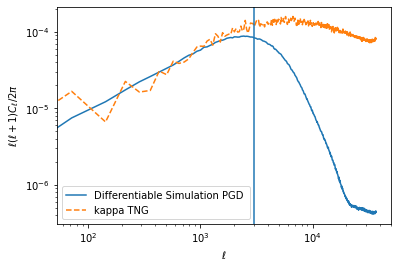

In [11]:
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation PGD ')
loglog(l, l*(l+1)*ps_TNG/(2*np.pi),'--',label='kappa TNG')
axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

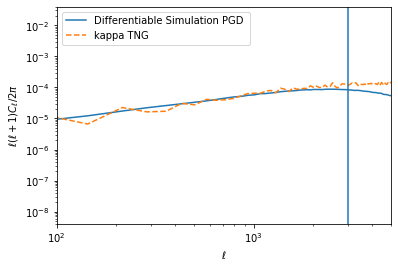

In [12]:
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation PGD ')
loglog(l, l*(l+1)*ps_TNG/(2*np.pi),'--',label='kappa TNG')
xlim(1e2,5e3)
ylim(4e-9,4e-2)
axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [13]:
ngal = 10                          # gal/arcmin **2
pix_scale = 5/1024*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels (I think)
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [14]:
sigma_pix_2ar=2/pix_scale

In [15]:
def rebin(a, shape):
    sh = shape,a.shape[0]//shape
    return tf.math.reduce_mean(tf.reshape(a,sh),axis=-1)

In [16]:
ps_array_2arc=[]
for kmap in (kmap_array):
    l, ps_FLP_2arc= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kmap[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
    l1= tf.where(l < 9000, False, True)
    l = tf.boolean_mask(l, tf.math.logical_not(l1))
    ps_FLP_2arc = tf.boolean_mask(ps_FLP_2arc, tf.math.logical_not(l1))
    l=rebin(l,25)
    ps_FLP_2arc=rebin(ps_FLP_2arc,25)
    ps_array_2arc.append(ps_FLP_2arc)


In [17]:
ps_2arc_mean=np.mean(ps_array_2arc,axis=0)

In [18]:
l, ps_TNG_2arc=DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kTNG,11,sigma=sigma_pix_2ar),field_size,field_npix)
l1= tf.where(l < 9000, False, True)
l = tf.boolean_mask(l, tf.math.logical_not(l1))
ps_TNG_2arc = tf.boolean_mask(ps_TNG_2arc, tf.math.logical_not(l1))
l=rebin(l,25)
ps_TNG_2arc=rebin(ps_TNG_2arc,25)

(-0.5, 1023.5, 1023.5, -0.5)

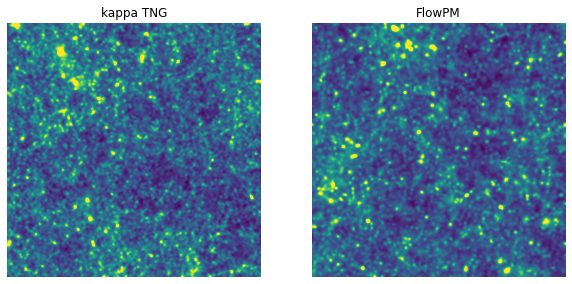

In [19]:
# Here is what it looks like with noise 
figure(figsize=[10,20])
subplot(121)
title('kappa TNG')
imshow(tfa.image.gaussian_filter2d(kTNG,11,sigma=sigma_pix_2ar), vmax=0.05)
axis('off')
subplot(122)
title('FlowPM')
imshow(tfa.image.gaussian_filter2d(kmap_array[0][0],11,sigma=sigma_pix_2ar), vmax=0.05)
axis('off')

Text(0.5, 1.0, 'Comparison to kappaTNG 2 arcmin smoothing')

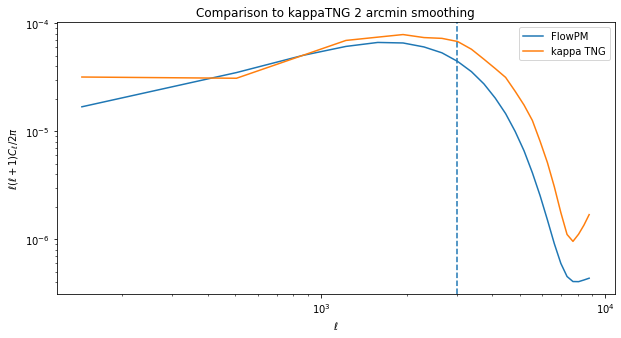

In [20]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_2arc_mean/(2*np.pi), label='FlowPM')
loglog(l, l*(l+1)*ps_TNG_2arc/(2*np.pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG 2 arcmin smoothing')

## Adding noise

We'll now try to get to a realistic setting that matches some of the SRD Y1 settings.

In [21]:
ps_array_2arc_n=[]
for kmap in (kmap_array):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    l, ps_FLP_2arc_n= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kmap[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
    l1= tf.where(l < 9000, False, True)
    l = tf.boolean_mask(l, tf.math.logical_not(l1))
    ps_FLP_2arc_n = tf.boolean_mask(ps_FLP_2arc_n, tf.math.logical_not(l1))
    l=rebin(l,25)
    ps_FLP_2arc_n=rebin(ps_FLP_2arc_n,25)
    ps_array_2arc_n.append(ps_FLP_2arc_n)


In [22]:
ps_2arc_n_mean=np.mean(ps_array_2arc_n,axis=0)

In [23]:
knTNG_n = np.load('kappa_tng.npy')+ sigma_e * randn(1024,1024), 5*u.deg
l, ps_TNG_2arc_n=DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(knTNG_n[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
l1= tf.where(l < 9000, False, True)
l = tf.boolean_mask(l, tf.math.logical_not(l1))
ps_TNG_2arc_n = tf.boolean_mask(ps_TNG_2arc_n, tf.math.logical_not(l1))
l=rebin(l,25)
ps_TNG_2arc_n=rebin(ps_TNG_2arc_n,25)


Text(0.5, 1.0, 'FlowPM')

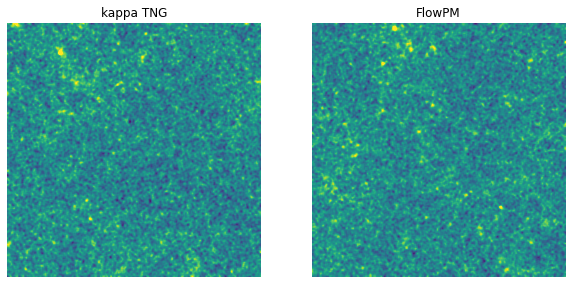

In [24]:
# Here is what it looks like with noise 
figure(figsize=[10,20])
subplot(121)
title('kappa TNG')
imshow(tfa.image.gaussian_filter2d(knTNG_n[0],11,sigma=sigma_pix_2ar), vmax=0.1)
axis('off')
subplot(122)
title('FlowPM')
imshow(tfa.image.gaussian_filter2d(kmap_array[0][0]+ sigma_e * randn(1024,1024),11,sigma=sigma_pix_2ar), vmax=0.1)
axis('off')
title('FlowPM')



Text(0.5, 1.0, 'Comparison to kappaTNG 2 arcmin smoothing and noise')

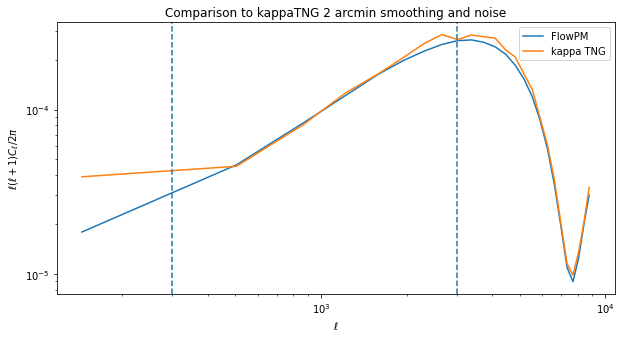

In [25]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_2arc_n_mean/(2*np.pi), label='FlowPM')
loglog(l, l*(l+1)*ps_TNG_2arc_n/(2*np.pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
axvline(300,ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG 2 arcmin smoothing and noise')



## Let's also compare native peak counts

In [26]:
counts_FLP_array=[]
bins_FLP_array=[]
center_FLP_array=[]
for kmap in (kmap_array):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    counts_FLP,bins_FLP=DHOS.statistics.peaks_histogram_tf(tfa.image.gaussian_filter2d(np.float32(kmap[0]),11,sigma=sigma_pix_2ar))
    center_FLP = (bins_FLP[:-1] + bins_FLP[1:]) / 2
    counts_FLP_array.append(counts_FLP)
    bins_FLP_array.append(bins_FLP)
    center_FLP_array.append(center_FLP)

In [27]:
counts_TNG, bins_TNG=DHOS.statistics.peaks_histogram_tf(tfa.image.gaussian_filter2d(np.float32(knTNG_n[0]),11,sigma=sigma_pix_2ar))

In [28]:
center_TNG = (bins_TNG[:-1] + bins_TNG[1:]) / 2


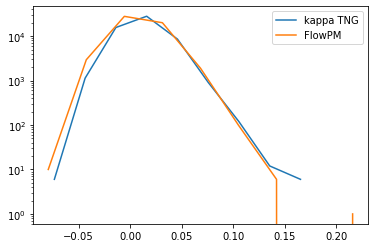

In [29]:
semilogy(center_FLP_array[15], counts_FLP_array[15], label='kappa TNG')
semilogy(center_TNG, counts_TNG, label='FlowPM')
legend()

In [30]:
counts_FLP_mean=np.mean(counts_FLP_array,axis=0)
center_FLP_mean=np.mean(center_FLP_array,axis=0)

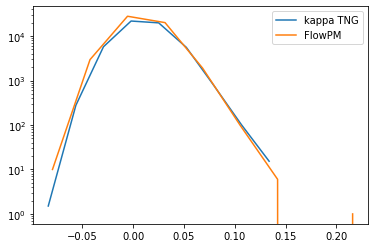

In [31]:
semilogy(center_FLP_mean, counts_FLP_mean, label='kappa TNG')
semilogy(center_TNG, counts_TNG, label='FlowPM')
legend()

## Let's also compare the l1norm

In [32]:
l1norm_FLO_array=[] 
for kmap in (kmap_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=tfa.image.gaussian_filter2d(np.float32(kmap[0][0]),11,sigma=sigma_pix_2ar)
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_FLO= DHOS.statistics.l1norm(kmap, nbins=7, value_range=[-0.05, 0.05])[1][0]
    l1norm_FLO_array.append(l1norm_FLO)

In [33]:
knTNG_n__2arc=tfa.image.gaussian_filter2d(np.float32(knTNG_n[0]),11,sigma=sigma_pix_2ar)
knTNG_n__2arc=tf.expand_dims(knTNG_n__2arc, axis=0)
l1norm_TNG=DHOS.statistics.l1norm(knTNG_n__2arc, nbins=7, value_range=[-0.05, 0.05])[1][0]

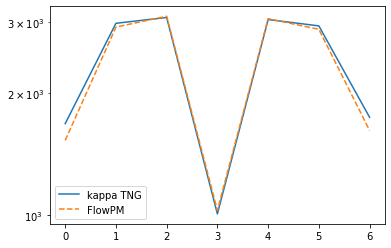

In [34]:
semilogy(l1norm_TNG, label='kappa TNG')
semilogy(l1norm_FLO_array[0],'--',label='FlowPM',)
legend()